# Практическое задание. 

Сначала идет реализация случайного леса с лекции. Задания будут ниже:

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification

import numpy as np

Реализуем генерацию $N$ бутстрап-выборок и подмножества признаков для нахождения разбиения в узле.

In [2]:
def get_bootstrap(data, labels, N):
    n_samples = data.shape[0] # размер совпадает с исходной выборкой
    bootstrap = []
    
    for i in range(N):
        
        sample_index = np.random.randint(0, n_samples, size=n_samples)
        b_data = data[sample_index]
        b_labels = labels[sample_index]
        
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [3]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = list(range(len_sample))

    len_subsample = int(np.sqrt(len_sample))
    
    subsample = np.random.choice(sample_indexes, size=len_subsample, replace=False)

    return subsample

Далее повторим реализацию построения дерева решений из предыдущего урока с некоторыми изменениями

In [4]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [5]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [6]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [7]:
# Расчет прироста

def gain(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [8]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [9]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf_samples = 5

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    feature_subsample_indices = get_subsample(n_features) # выбираем случайные признаки
    
    for index in feature_subsample_indices:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
#             if len(true_data) < min_leaf_samples or len(false_data) < min_leaf_samples:
#                 continue
            
            current_gain = gain(true_labels, false_labels, root_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [10]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

Теперь добавим функцию формирования случайного леса.

In [11]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap: 
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [12]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [13]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [14]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
#     print(predictions)

    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
#     print(predictions_per_object)

    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [15]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
import random
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

## Задание 1 и 2.
Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).

Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

In [17]:
X, y = make_classification(n_samples=100,
                           n_features=2, n_informative=2, 
                           n_classes=2, n_redundant=0, 
                           n_clusters_per_class=1, random_state=22, flip_y=0.4) 
# Немного усложнил задачу добавив flip_y
#  """Larger values introduce noise in the labels and make the classification task harder."""

In [18]:
train_data, test_data, train_labels, test_labels = train_test_split(X, 
                                                                    y, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [19]:
tree1 = random_forest(train_data, train_labels, 1)
tree3 = random_forest(train_data, train_labels, 3)
tree10 = random_forest(train_data, train_labels, 10)
tree50 = random_forest(train_data, train_labels, 50)

In [20]:
train_answers1 = tree_vote(tree1, train_data)
train_answers3 = tree_vote(tree3, train_data)
train_answers10 = tree_vote(tree10, train_data)
train_answers50 = tree_vote(tree50, train_data)
test_answers1 = tree_vote(tree1, test_data)
test_answers3 = tree_vote(tree3, test_data)
test_answers10 = tree_vote(tree10, test_data)
test_answers50 = tree_vote(tree50, test_data)

In [21]:
train_accuracy1 = accuracy_metric(train_labels, train_answers1)
train_accuracy3 = accuracy_metric(train_labels, train_answers3)
train_accuracy10 = accuracy_metric(train_labels, train_answers10)
train_accuracy50 = accuracy_metric(train_labels, train_answers50)
test_accuracy1 = accuracy_metric(test_labels, test_answers1)
test_accuracy3 = accuracy_metric(test_labels, test_answers3)
test_accuracy10 = accuracy_metric(test_labels, test_answers10)
test_accuracy50 = accuracy_metric(test_labels, test_answers50)


print(f'Точность случайного леса из:\n********\n \
{1} деревьев: \n train:{train_accuracy1}\n test:{test_accuracy1}\n********\n\
{3} деревьев: \n train:{train_accuracy3}\n test:{test_accuracy3}\n********\n\
{10} деревьев: \n train:{train_accuracy10}\n test:{test_accuracy10}\n********\n\
{50} деревьев: \n train:{train_accuracy50}\n test:{test_accuracy50}\n********\n')

Точность случайного леса из:
********
 1 деревьев: 
 train:87.14285714285714
 test:53.333333333333336
********
3 деревьев: 
 train:87.14285714285714
 test:36.666666666666664
********
10 деревьев: 
 train:100.0
 test:66.66666666666666
********
50 деревьев: 
 train:100.0
 test:53.333333333333336
********



In [22]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


#ИЗМЕНЕНИЕ добавил my_tree, train_labels, train_accuracy в параметры ф-ии, чтобы менять модель.
def visualize(train_data, train_labels, train_accuracy, my_tree, test_data, test_labels, test_accuracy):     
    plt.figure(figsize = (16, 7))
    # Цвета добавлены в функцию
    colors = ListedColormap(['red', 'blue'])
    light_colors = ListedColormap(['lightcoral', 'lightblue'])

    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    # Изменено predict на tree_vote, а так же изменены местами параметры ф-ии tree_vote
    mesh_predictions = np.array(tree_vote(my_tree, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')
    
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')

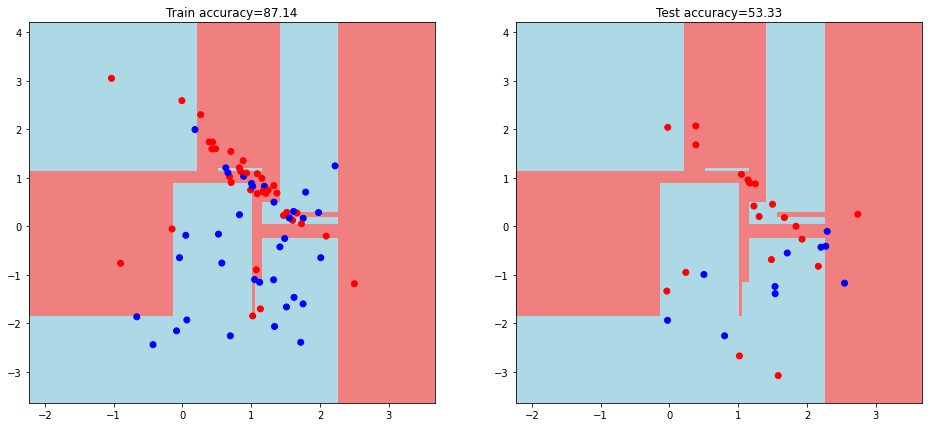

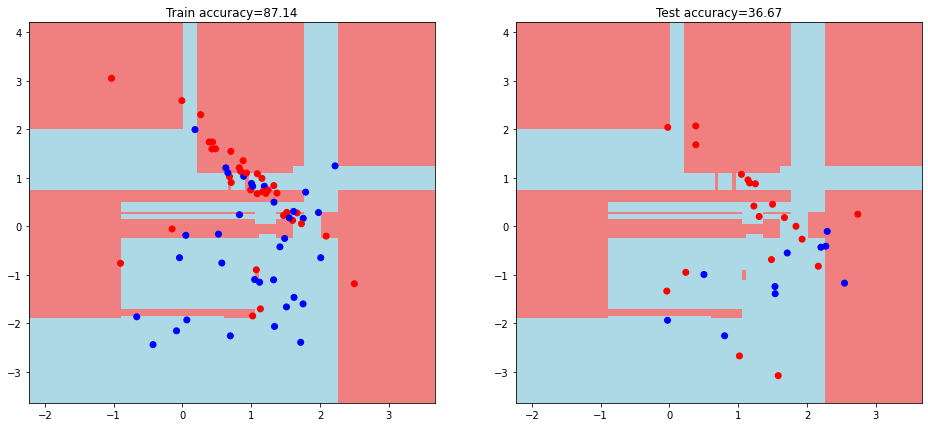

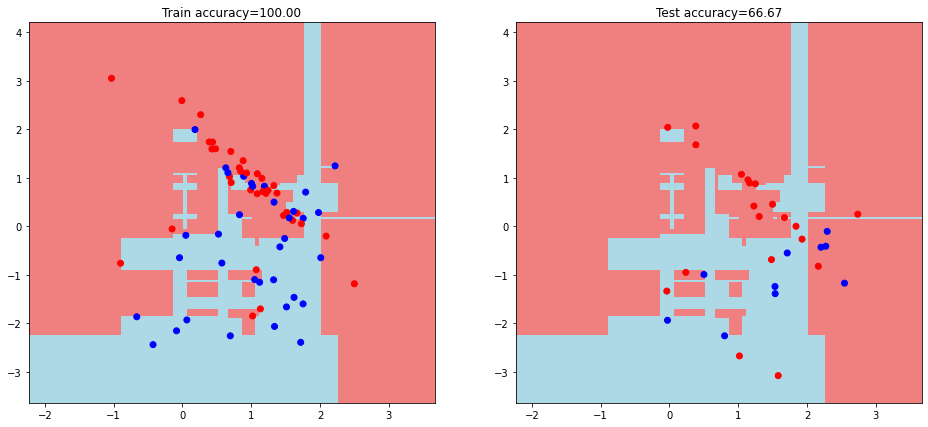

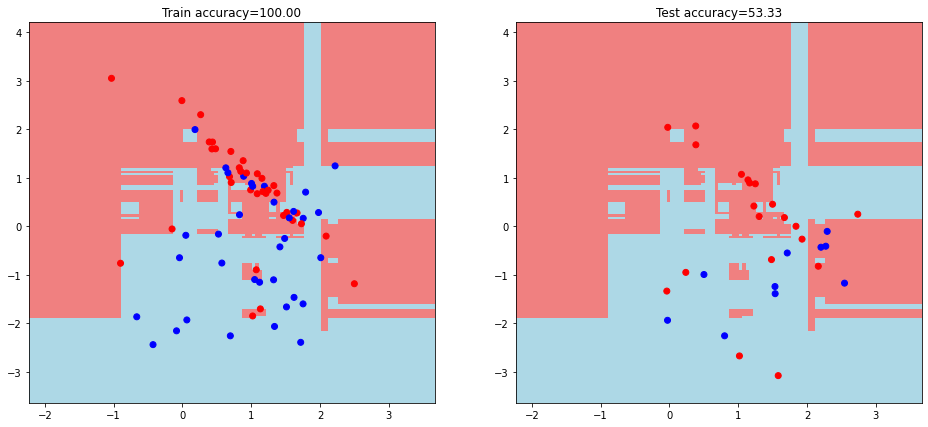

In [23]:
visualize(train_data, train_labels, train_accuracy1, tree1, test_data, test_labels, test_accuracy1)
visualize(train_data, train_labels, train_accuracy3, tree3, test_data, test_labels, test_accuracy3)
visualize(train_data, train_labels, train_accuracy10, tree10, test_data, test_labels, test_accuracy10)
visualize(train_data, train_labels, train_accuracy50, tree50, test_data, test_labels, test_accuracy50)
plt.show();

Вывод: С увеличением количеств деревьев в случайном лесу, метрика accuracy на трейне увеличивается, но это вовсе не значит, что на тесте эта же метрика будет хорошей, как видим чем больше деревьев, тем сложнее становится модель, тем больше она улавливает мельчайших изменений в данных, и находит закономерности, где возможно этих закономерностей и не имеется вовсе. Судя по всему, очень много зависит так же от данных, я эксперементировал с разными гиперпараметрами make_classification, и иногда было достаточно даже 1 дерева в случайном лесе, чтобы добиться неплохого результата. В целом, видно, что случайный лес можно переобучить, как раз на последнем примере, где 50 деревьев, accuracy на трейне 100, а не тесте гораздо меньше.

## Задание 3.
Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

Создадим небольшой датасет из 10 объектов. Небольшим я его для того, чтобы можно было визуализировать и вывести работу функций ниже.

In [24]:
X, y = make_classification(n_samples=10,
                           n_features=2, n_informative=2, 
                           n_classes=2, n_redundant=0, 
                           n_clusters_per_class=1, random_state=22, flip_y=0.05) 

In [25]:
def get_bootstrap(data, labels, N):
    n_samples = data.shape[0] 
    bootstrap = []
    
    for i in range(N):
        
        sample_index = np.random.randint(0, n_samples, size=n_samples)
        b_data = data[sample_index]
        b_labels = labels[sample_index]
        
        ### ИЗМЕНЕНИЯ
        # Создаю переменную oob_index, которая возвращает индексы объектов, невошедшие в бутстрап.
        oob_index = [el for el in range(len(data)) if el not in sample_index]
        
        # Добавляю в каждый бутстрап помимо данных и таргетов, еще и индексы невошедших туда объектов.
        bootstrap.append((b_data, b_labels, oob_index))
        ### ИЗМЕНЕНИЯ
        
    return bootstrap

In [26]:
def random_forest(data, labels, n_trees):
    
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees) 
    
    not_trained_on = {} # словарь типа "индекс объекта: [индексы деревьев, не обучавшиеся на этом объекте]"
    tree_index = 0 # инкремент, начинаем с дерева с индексом 0
    for b_data, b_labels, oob_index in bootstrap: # не забываем, что бустрап еще теперь имеет индексы oob объектов.
        forest.append(build_tree(b_data, b_labels)) # добавляем в случайный лес обученное дерево
        for el in oob_index: # для каждого индекса oob объекта
            if el not in not_trained_on: # если индекса еще нет в словаре
                not_trained_on[el] = [tree_index] # то присваем индексу объекта индекс дерева, которое не обучалось
            else:
                not_trained_on[el].append(tree_index) # если индекс уже есть в словаре, то добавляем индекс дерева
        tree_index += 1 # увеличиваем инкремент (индекс дерева)
    
    forest.append(not_trained_on) # закидываем получившийся словарь последним элементом в случайный лес
    return forest

In [27]:
def tree_vote(forest, data):

    # Эта часть с предсказаниями без изменений.
    predictions = []
    for tree in forest[:-1]:
        predictions.append(predict(data, tree))

    predictions_per_object = list(zip(*predictions))

    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
    
    
    ### ИЗМЕНЕНИЯ
    oob_predictions = {} # Словарь, где мы будем хранить предсказанные значения для каждого Out of Bag объекта 
    
    for key in sorted(tree_test[-1].keys()): # для каждого индекса объекта
        predictions_for_key = []
        for tree in tree_test[-1][key]: # для каждого дерева, которое не обучалось на нашем объекте
            print(f'Объект с индексом {key}, Дерево с индексом {tree}')
            predictions_for_key.append(classify_object(data[key], forest[tree])) # классифицируем объект деревом
        print(f'Предсказание: {predictions_for_key}')
        oob_predictions[key] = max(predictions_for_key, key=predictions_for_key.count) # после цикла финальное предсказание
        print(f'Финальное предсказание: {max(predictions_for_key, key=predictions_for_key.count)}')
    
    return voted_predictions, list(oob_predictions.values()) # возвращаем настоящие предсказания, и Out of Bag
    ### ИЗМЕНЕНИЯ

Тестируем:

In [28]:
tree_test = random_forest(X, y, 10)

Ниже словарь с индексами объектов и индексами деревьев, которые не обучались на данном объекте.

In [29]:
tree_test[-1]

{0: [0, 2, 3, 4, 6, 8],
 1: [0, 4, 6, 8],
 2: [0, 2, 5, 7],
 7: [0, 2, 3, 4, 5],
 8: [0, 1, 3, 8],
 3: [1, 7, 8, 9],
 4: [1, 6],
 5: [1, 2, 6, 9],
 9: [1, 2, 5, 7],
 6: [3, 9]}

Подсчитаем сколько раз деревья пропустили те или иные объекты, и не обучались на них:

In [30]:
count_of_elements_missed_by_trees = sum( [ len(el) for el in list(tree_test[-1].values())])
count_of_elements_missed_by_trees

39

In [31]:
total_count_of_elements = 10*10 #Кол-во объектов, умноженное на кол-во деревьев в случайном лесе
total_count_of_elements

100

In [32]:
print(f'Примерно не попало в основную выборку \
обучения случайного леса {int(count_of_elements_missed_by_trees/total_count_of_elements*100)}% данных')

Примерно не попало в основную выборку обучения случайного леса 39% данных


Похоже на правду!

Немножко логирования, посмотрим:

In [33]:
voted, oob = tree_vote(tree_test, X)

Объект с индексом 0, Дерево с индексом 0
Объект с индексом 0, Дерево с индексом 2
Объект с индексом 0, Дерево с индексом 3
Объект с индексом 0, Дерево с индексом 4
Объект с индексом 0, Дерево с индексом 6
Объект с индексом 0, Дерево с индексом 8
Предсказание: [1, 1, 1, 1, 1, 1]
Финальное предсказание: 1
Объект с индексом 1, Дерево с индексом 0
Объект с индексом 1, Дерево с индексом 4
Объект с индексом 1, Дерево с индексом 6
Объект с индексом 1, Дерево с индексом 8
Предсказание: [0, 0, 1, 1]
Финальное предсказание: 0
Объект с индексом 2, Дерево с индексом 0
Объект с индексом 2, Дерево с индексом 2
Объект с индексом 2, Дерево с индексом 5
Объект с индексом 2, Дерево с индексом 7
Предсказание: [0, 0, 0, 0]
Финальное предсказание: 0
Объект с индексом 3, Дерево с индексом 1
Объект с индексом 3, Дерево с индексом 7
Объект с индексом 3, Дерево с индексом 8
Объект с индексом 3, Дерево с индексом 9
Предсказание: [0, 0, 0, 0]
Финальное предсказание: 0
Объект с индексом 4, Дерево с индексом 1
Объ

Сверим метрики:

Случайный лес в нашем исполнении имеет 100 на трейне, и 60 на Out of Bag объектах.

In [34]:
oob

[1, 0, 0, 0, 1, 1, 0, 0, 1, 1]

In [35]:
accuracy_metric(voted, y)

90.0

In [36]:
accuracy_metric(oob, y)

60.0

Случайный лес в исполнении sklearn, имеет 100 на трейне, и 60 на Out of Bag объектах. Похоже не те же метрики, что имеет и наш случайный лес.

In [37]:
from sklearn.ensemble import RandomForestClassifier

In [38]:
classy = RandomForestClassifier(n_estimators=10,
                               oob_score=True)

In [39]:
classy.fit(X, y)

RandomForestClassifier(n_estimators=10, oob_score=True)

In [40]:
accuracy_metric(y, classy.predict(X))

100.0

In [41]:
classy.oob_score_

0.6

### Задание 4.
*(На повторение) Переписать функцию gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в entropy.

Создадим функцию расчета энтропии:

In [42]:
# Расчет Энтропии

def entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет энтропии:
    entropy_value = 0
    for label in classes:
        p = classes[label] / len(labels)
        if p != 0:
            entropy_value += p*np.log2(p)
        else: # Если вдруг доля объекта = 0, то не будем считать логарифм от нуля, иначе будет ошибка.
            entropy_value += 0
        
    return -1*entropy_value # не забываем добавить знак минуса

Изменим функцию gain (заменим gini на entropy):

In [43]:
# Расчет прироста

def gain(left_labels, right_labels, root_entropy):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_entropy - p * entropy(left_labels) - (1 - p) * entropy(right_labels)

Изменим gini на entropy в find_best_split функции (ничего нового тут не добавлено):

In [44]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf_samples = 5

    root_entropy = entropy(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    feature_subsample_indices = get_subsample(n_features) # выбираем случайные признаки
    
    for index in feature_subsample_indices:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
#             if len(true_data) < min_leaf_samples or len(false_data) < min_leaf_samples:
#                 continue
            
            current_gain = gain(true_labels, false_labels, root_entropy)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [45]:
entropy_forest = random_forest(X, y, 10)

Раз уж мы создали Out of Bag реализацию проверки, то и посмотрим смог ли обучиться случайный лес, в основе которого лежит энтропия:

In [46]:
voted, oob = tree_vote(entropy_forest, X)
# Вывод ниже это только предсказание на Out of Bag объектах. Основное предсказаниме происходит silently.

Объект с индексом 0, Дерево с индексом 0
Объект с индексом 0, Дерево с индексом 2
Объект с индексом 0, Дерево с индексом 3
Объект с индексом 0, Дерево с индексом 4
Объект с индексом 0, Дерево с индексом 6
Объект с индексом 0, Дерево с индексом 8
Предсказание: [1, 0, 1, 1, 0, 0]
Финальное предсказание: 1
Объект с индексом 1, Дерево с индексом 0
Объект с индексом 1, Дерево с индексом 4
Объект с индексом 1, Дерево с индексом 6
Объект с индексом 1, Дерево с индексом 8
Предсказание: [1, 0, 1, 1]
Финальное предсказание: 1
Объект с индексом 2, Дерево с индексом 0
Объект с индексом 2, Дерево с индексом 2
Объект с индексом 2, Дерево с индексом 5
Объект с индексом 2, Дерево с индексом 7
Предсказание: [1, 1, 1, 1]
Финальное предсказание: 1
Объект с индексом 3, Дерево с индексом 1
Объект с индексом 3, Дерево с индексом 7
Объект с индексом 3, Дерево с индексом 8
Объект с индексом 3, Дерево с индексом 9
Предсказание: [0, 0, 0, 0]
Финальное предсказание: 0
Объект с индексом 4, Дерево с индексом 1
Объ

In [47]:
oob

[1, 1, 1, 0, 0, 1, 1, 0, 1, 1]

In [48]:
print(f'Accuracy на трейне:{accuracy_metric(voted, y)}\nAccuracy OOB: {accuracy_metric(oob, y)}')

Accuracy на трейне:100.0
Accuracy OOB: 80.0


Раз мы имеем accuracy на 100, то можно сделать вывод, что лес смог обучиться на энтропии, и может правильно предсказывать принадлежность к классам.